## Notebook to test out freesufer stats output without using freesurfer utilities

In [44]:
import pandas as pd
import numpy as np
from freesurfer_stats import CorticalParcellationStats
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
    

In [45]:
data_dir = "/home/nikhil/projects/brain_changes/data/"

ukbb_dir = f"{data_dir}/ukbb/"
adni_dir = f"{data_dir}/adni/"

# DKT fields and labels
ukbb_dkt_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_FS_DKT_Fields.csv"
ukbb_dkt_ct_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_DKT_CT_Fields.csv"

# ASEG fields and labels
ukbb_aseg_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_FS_ASEG_Fields.csv"
ukbb_aseg_vol_fields = f"{data_dir}/ukbb/region_field_ids/UKBB_ASEG_vol_Fields.csv"

## Read agg CSVs after collating stats

### Note: 
- Desikan-Killiany-Tourville Atlas: Cortical Regions. Frontal pole, temporal pole, and “banks of the superior temporal sulcus” regions were removed as per the DKT protocol, 

### Read UKB data

In [28]:
ukbb_freesurfer_agg_dir = f"{ukbb_dir}/derivatives/freesurfer-agg/"
DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_sorted = list(DKT_fields_df.sort_values(["hemi","roi"])["Field ID"].astype(str).values)

62

In [42]:
# DKT_fields_df[DKT_fields_df["Field ID"]==27177]
DKT_fields_df[DKT_fields_df["roi"]=="entorhinal"]

,Unnamed: 0,Field ID,Description,metric,roi,hemi
6,68,27177,Mean_thickness of entorhinal (left hemisphere),Mean_thickness,entorhinal,lh
7,69,27270,Mean_thickness of entorhinal (right hemisphere),Mean_thickness,entorhinal,rh


In [35]:
proc_subset_list = ["pre_ohbm","post_ohbm","nov_2022"]
ses_list = ["ses-2","ses-3"]

CT_DKT_df = pd.DataFrame()
for proc_subset in proc_subset_list:    
    for ses in ses_list:
        if (proc_subset == "post_ohbm") & (ses == "ses-3"): 
            ses3_batch_list = ["ohbm_train_subjects_1-800","ohbm_train_subjects_801-1749"]
            for ses3_batch in ses3_batch_list:
                DKT_csv = f"{ukbb_freesurfer_agg_dir}/{proc_subset}/{ses}/{ses3_batch}/DKTatlas_average_thickness.csv"
                df = pd.read_csv(DKT_csv)
                df["session"] = ses
                # df["proc_subset"] = proc_subset
                CT_DKT_df = CT_DKT_df.append(df)
        else:
            DKT_csv = f"{ukbb_freesurfer_agg_dir}/{proc_subset}/{ses}/DKTatlas_average_thickness.csv"
            df = pd.read_csv(DKT_csv)
            df["session"] = ses
            # df["proc_subset"] = proc_subset
            CT_DKT_df = CT_DKT_df.append(df)

CT_DKT_df = CT_DKT_df.set_index("subject_id")
CT_DKT_ses_2_df = CT_DKT_df[CT_DKT_df["session"]=="ses-2"][DKT_fields_sorted]
CT_DKT_ses_3_df = CT_DKT_df[CT_DKT_df["session"]=="ses-3"][DKT_fields_sorted]

# Diff = BL - FU
CT_diff_df = CT_DKT_ses_2_df - CT_DKT_ses_3_df
CT_diff_df = CT_diff_df.reset_index()
print(f"Shape of CT_DKT_df: {CT_diff_df.shape}")
CT_diff_df.head()

Shape of CT_DKT_df: (4696, 63)


,subject_id,27174,27175,27176,27177,27178,27179,27180,27204,27181,...,27287,27288,27289,27290,27291,27292,27293,27294,27295,27296
0,sub-1000635,-0.131,0.078,0.073,0.029,0.030,0.130,0.147,0.023,0.017,...,0.051,0.180,0.090,-0.146,0.105,0.008,-0.043,0.145,0.108,0.093
1,sub-1004084,0.174,-0.061,0.039,-0.060,-0.069,-0.044,-0.129,-0.117,-0.036,...,-0.135,-0.075,-0.048,-0.055,-0.034,-0.120,-0.023,-0.010,0.005,-0.034
2,sub-1008391,-0.263,-0.035,0.024,0.248,-0.065,-0.083,-0.155,0.074,0.067,...,0.054,0.202,0.013,-0.180,-0.056,-0.088,-0.006,0.128,0.038,-0.145
3,sub-1009663,0.186,0.017,-0.019,0.039,-0.035,-0.014,0.027,0.010,0.067,...,0.027,-0.001,0.030,-0.041,-0.027,-0.091,-0.039,-0.025,-0.024,0.044
4,sub-1010063,0.028,0.004,0.002,0.206,0.050,0.075,0.103,0.075,0.010,...,0.137,0.017,0.036,0.067,-0.020,0.063,0.070,0.009,0.024,-0.059


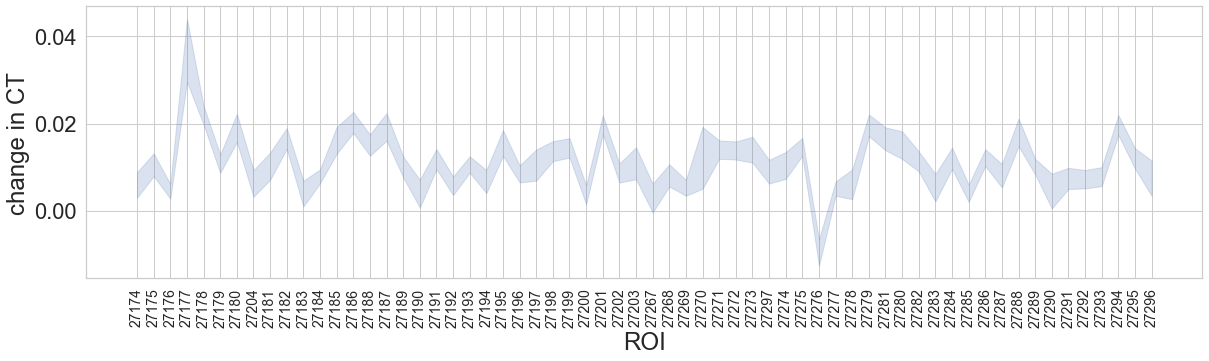

In [43]:
CT_diff_df_melt = CT_diff_df.melt(
    id_vars=["subject_id"],
    var_name="ROI", 
    value_name="change in CT",
)
CT_diff_df_melt.head()

plot_df = CT_diff_df_melt.copy()
plot_df = plot_df.rename(columns={"COLPROT":"cohort"})
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    fig,ax=plt.subplots(figsize=(20,5))
    # g = sns.catplot(x="ROI",y="change in CT",kind="point",aspect=4,data=plot_df)
    g = sns.lineplot(x="ROI",y="change in CT", #order=DKT_fields_sorted: Not easy to change order
    linestyle="",data=plot_df,ax=ax)
    
    g.tick_params(axis='x', rotation=90, labelsize=14)
    # plt.legend(loc='center left', bbox_to_anchor=(0.1, 1.1), ncol=5)

### Read ADNI data

In [51]:
adnimerge_file = f"{adni_dir}/tabular/ADNIMERGE.csv"

visit_id = "bl"
FS_stats_dir = f"{adni_dir}adni123_bl_m24_July_2022/derivatives/freesurfer_agg/ses-{visit_id}/"
BL_CT_file = f"{FS_stats_dir}/DKTatlas_average_thickness.csv"
BL_ASEG_file = f"{FS_stats_dir}/aseg_subcortical_volumes.csv"

visit_id = "m24"
FS_stats_dir = f"{adni_dir}adni123_bl_m24_July_2022/derivatives/freesurfer_agg/ses-{visit_id}/"
FU_CT_file = f"{FS_stats_dir}/DKTatlas_average_thickness.csv"
FU_ASEG_file = f"{FS_stats_dir}/aseg_subcortical_volumes.csv"

In [52]:
BL_CT_df = pd.read_csv(BL_CT_file).drop(columns=["Unnamed: 0"]).set_index("subject_id")
BL_ASEG_df = pd.read_csv(BL_ASEG_file).drop(columns=["Unnamed: 0"]).set_index("subject_id")
FU_CT_df = pd.read_csv(FU_CT_file).drop(columns=["Unnamed: 0"]).set_index("subject_id")
FU_ASEG_df = pd.read_csv(FU_ASEG_file).drop(columns=["Unnamed: 0"]).set_index("subject_id")

print(f"Number of BL, CT subjects: {len(BL_CT_df)}, number of ROIs: 2 x {len(BL_CT_df.columns)/2}")
print(f"Number of BL, ASEG subjects: {len(BL_ASEG_df)}, number of ROIs: {len(BL_ASEG_df.columns)}")

print(f"Number of FU, CT subjects: {len(FU_CT_df)}, number of ROIs: 2 x {len(FU_CT_df.columns)/2}")
print(f"Number of FU, ASEG subjects: {len(FU_ASEG_df)}, number of ROIs: {len(FU_ASEG_df.columns)}")

## Ensures the visit has both DKT and ASEG data
BL_subjects = set(BL_CT_df.index) & set(BL_ASEG_df.index)
FU_subjects = set(FU_CT_df.index) & set(FU_ASEG_df.index)

BL_and_FU_subjects = list(BL_subjects & FU_subjects)

## Some outlier that need to be looked at (most likely proc failures)
drop_subjects = ["sub-ADNI082S4244"] #sub-ADNI082S4244 --> super low inter-visit correlation

for ds in drop_subjects:
    BL_and_FU_subjects.remove(ds)

print(f"Number unique subjects with CT and ASEG features\n BL: {len(BL_subjects)}, \
FU: {len(FU_subjects)}, dropped subjects: {len(drop_subjects)}, BLandFU: {len(BL_and_FU_subjects)}")

Number of BL, CT subjects: 1211, number of ROIs: 2 x 31.0
Number of BL, ASEG subjects: 1211, number of ROIs: 36
Number of FU, CT subjects: 1102, number of ROIs: 2 x 31.0
Number of FU, ASEG subjects: 1102, number of ROIs: 36
Number unique subjects with CT and ASEG features
 BL: 1211, FU: 1102, dropped subjects: 1, BLandFU: 1092


### Read ADNIMERGE

In [53]:
useful_cols = ["PTID","DX_bl","AGE","PTGENDER","VISCODE","COLPROT"]

adnimerge_df = pd.read_csv(adnimerge_file, usecols=useful_cols)
print(f"ADNIMERGE len: {len(adnimerge_df)}")

adnimerge_df["subject_id"] = "sub-ADNI" + adnimerge_df["PTID"]
adnimerge_df["subject_id"] = adnimerge_df["subject_id"].str.replace("_","")


adnimerge_dx_df = adnimerge_df[(adnimerge_df["subject_id"].isin(BL_and_FU_subjects)) & (adnimerge_df["VISCODE"]=="bl")]

print(f"adnimerge with longitudinal subjects. n_subjects = {len(adnimerge_dx_df)}")
adnimerge_dx_df.head()

ADNIMERGE len: 16014
adnimerge with longitudinal subjects. n_subjects = 1092


,COLPROT,PTID,VISCODE,DX_bl,AGE,PTGENDER,subject_id
1,ADNI1,011_S_0003,bl,AD,81.3,Male,sub-ADNI011S0003
10,ADNI1,011_S_0005,bl,CN,73.7,Male,sub-ADNI011S0005
15,ADNI1,100_S_0006,bl,LMCI,80.4,Female,sub-ADNI100S0006
20,ADNI1,022_S_0007,bl,AD,75.4,Male,sub-ADNI022S0007
22,ADNI1,011_S_0010,bl,AD,73.9,Female,sub-ADNI011S0010


### Brain-age sample demographics

In [54]:
adnimerge_dx_df.groupby(["COLPROT","DX_bl"]).count()

PTID  VISCODE  AGE  PTGENDER  subject_id
COLPROT DX_bl                                          
ADNI1   AD      112      112  112       112         112
        CN      178      178  178       178         178
        LMCI    251      251  251       251         251
ADNI2   AD       17       17   17        17          17
        CN      109      109  109       109         109
        EMCI    101      101  101       101         101
        LMCI     88       88   88        88          88
        SMC      49       49   49        49          49
ADNI3   AD        8        8    8         8           8
        CN       24       24   24        24          24
        EMCI     16       16   16        16          16
        LMCI     19       19   19        19          19
        SMC      55       55   55        55          55
ADNIGO  EMCI     65       65   65        65          65

### Difference in CT over time

In [55]:
def get_anat_change(BL_df, FU_df):
    """ Function to calculate *SUBJECT-LEVEL* average change and similarity in anatomical features between two visits. 
        change = BL - FU
        similarty = BL corrwith FU        
    """
    diff_df = BL_df - FU_df

    avg_diff_df = diff_df.mean(axis=1).copy().reset_index()
    avg_diff_df = avg_diff_df.rename(columns={0:"Avg Change"})

    corr_df = BL_df.corrwith(FU_df,axis=1).reset_index()
    corr_df = corr_df.rename(columns={0:"inter-visit-corr"})

    return avg_diff_df, corr_df


In [56]:
BL_CT_df_subset = BL_CT_df.loc[BL_and_FU_subjects].copy()
FU_CT_df_subset = FU_CT_df.loc[BL_and_FU_subjects].copy()

CT_diff_df = BL_CT_df_subset - FU_CT_df_subset
CT_diff_df = pd.merge(CT_diff_df.reset_index(), adnimerge_dx_df[["subject_id","DX_bl","COLPROT"]], on="subject_id")
print(f"Number of subjects with two visit data: {len(CT_diff_df)}")

CT_avg_diff_df, CT_corr_df = get_anat_change(BL_CT_df_subset,FU_CT_df_subset)

CT_avg_diff_df = pd.merge(CT_avg_diff_df, adnimerge_dx_df[["subject_id","DX_bl","COLPROT"]], on="subject_id")
CT_corr_df = pd.merge(CT_corr_df, adnimerge_dx_df[["subject_id","DX_bl","COLPROT"]], on="subject_id")

Number of subjects with two visit data: 1092


## Plots

/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


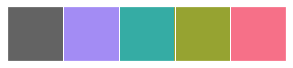

In [57]:
dx_order = ["CN","SMC","EMCI","LMCI","AD"]
cohort_order = ["ADNI1","ADNI2","ADNI3"] #ADNIGO only has EMCI

## Colors
pal = ["#636363"] + sns.color_palette("husl", 4)[::-1]
sns.palplot(pal)

### ROI-wise distribution

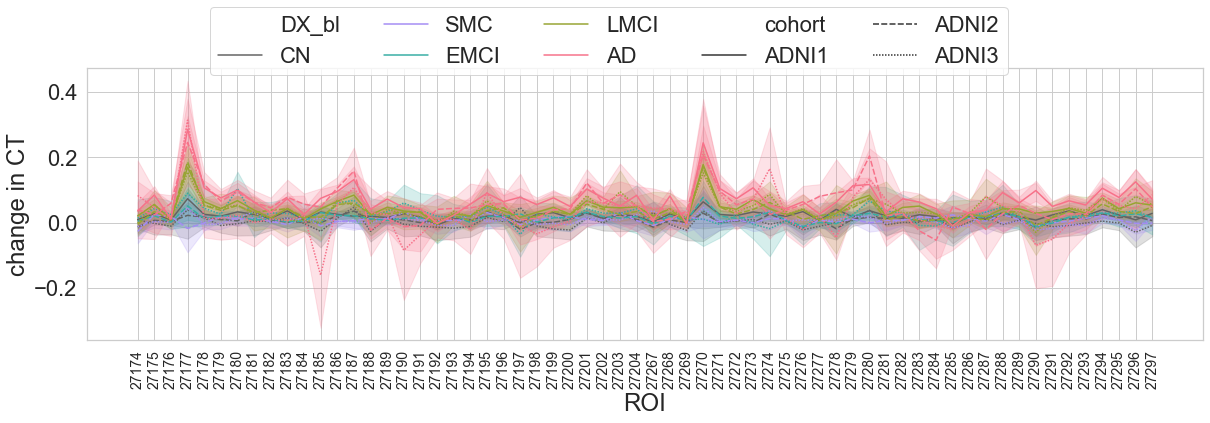

In [58]:
DKT_fields_df = pd.read_csv(ukbb_dkt_ct_fields)
DKT_fields_sorted = list(DKT_fields_df.sort_values(["hemi","roi"])["Field ID"].astype(str).values)

CT_diff_df_melt = CT_diff_df.melt(
    id_vars=["subject_id","DX_bl","COLPROT"],
    var_name="ROI", 
    value_name="change in CT",
)
CT_diff_df_melt.head()

plot_df = CT_diff_df_melt.copy()
plot_df = plot_df.rename(columns={"COLPROT":"cohort"})
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    fig,ax=plt.subplots(figsize=(20,5))
    # g = sns.catplot(x="ROI",y="CT",kind="point",hue="DX_bl",hue_order=hue_order, linestyle="",palette=pal, aspect=4,data=plot_df)
    g = sns.lineplot(x="ROI",y="change in CT", #order=DKT_fields_sorted: Not easy to change order
    hue="DX_bl",hue_order=dx_order, style="cohort", style_order=cohort_order,
    linestyle="",palette=pal,data=plot_df,ax=ax)
    
    g.tick_params(axis='x', rotation=90, labelsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(0.1, 1.1), ncol=5)



### Subject-wise change

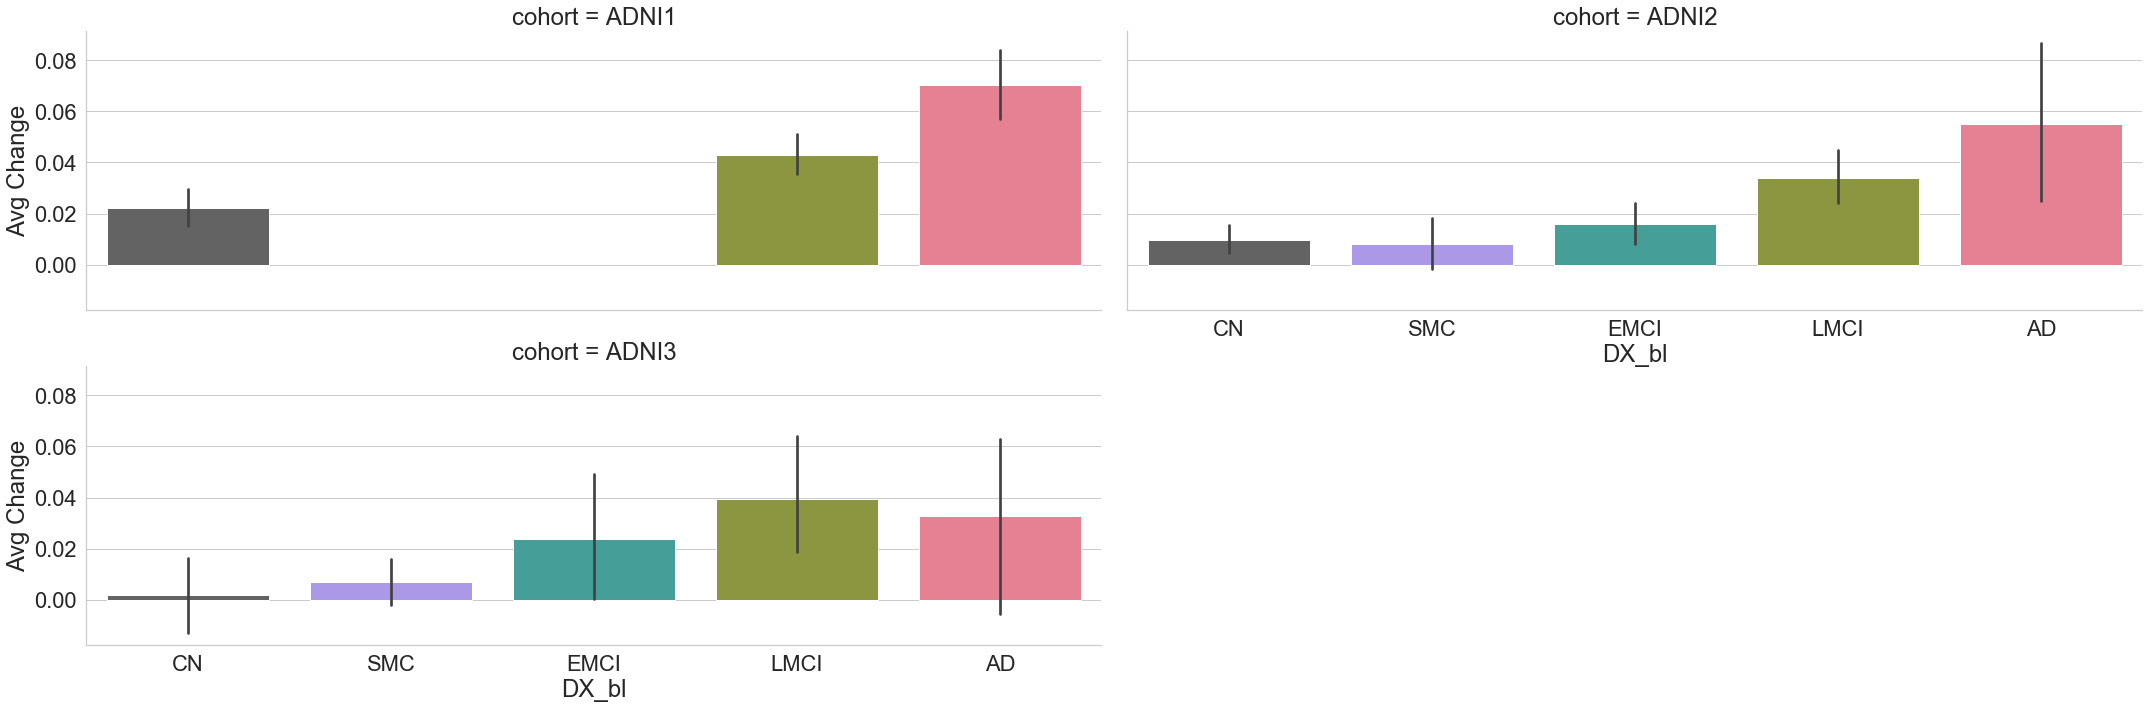

In [65]:
plot_df = CT_avg_diff_df.copy()
plot_df = plot_df.rename(columns={"COLPROT":"cohort"})
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="DX_bl",y="Avg Change",col="cohort", kind="bar", col_wrap=2,
    order=dx_order, col_order=cohort_order, aspect=3,data=plot_df, palette=pal)


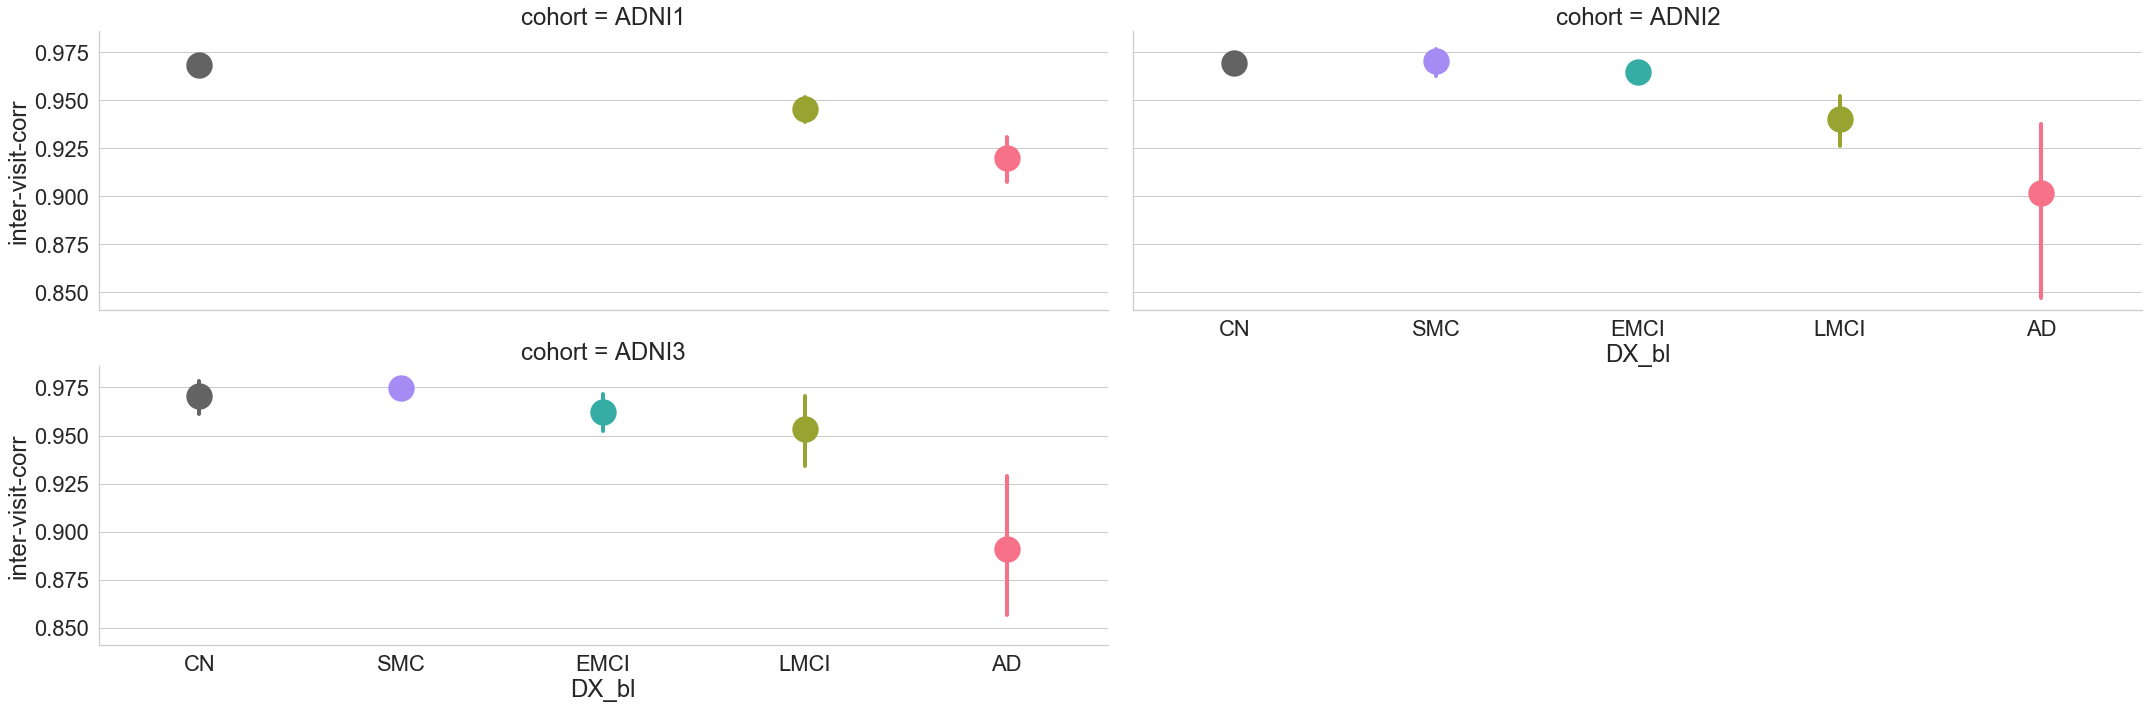

In [66]:
plot_df = CT_corr_df.copy()
plot_df = plot_df.rename(columns={"COLPROT":"cohort"})

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="inter-visit-corr",x="DX_bl", order=dx_order, kind="point", 
    hue="DX_bl", hue_order=dx_order,
    col="cohort", col_wrap=2, col_order=cohort_order,
    scale=3, errwidth=4, palette=pal, aspect=3, data=plot_df)

### Save available adni longitudinal data into single CSV

In [11]:
# adni_FS_DKT_csv = f"{data_dir}adni/imaging/freesurfer/adni_followup_subset_DKT.csv"
# adni_FS_aseg_csv = f"{data_dir}adni/imaging/freesurfer/adni_followup_subset_aseg.csv"

# # DKT (CT)
# BL_CT_df_subset = BL_CT_df.loc[BL_and_FU_subjects].copy()
# FU_CT_df_subset = FU_CT_df.loc[BL_and_FU_subjects].copy()

# CT_cols = BL_CT_df_subset.columns
# CT_cols_ses2 = list(CT_cols.astype(str) + "-2.0")
# CT_cols_ses3 = list(CT_cols.astype(str) + "-3.0")

# BL_CT_df_subset = BL_CT_df_subset.rename(columns=dict(zip(CT_cols,CT_cols_ses2)))
# FU_CT_df_subset = FU_CT_df_subset.rename(columns=dict(zip(CT_cols,CT_cols_ses3)))

# CT_subset_df = pd.concat([BL_CT_df_subset,FU_CT_df_subset],axis=1)
# CT_subset_df.to_csv(adni_FS_DKT_csv)

# # ASEG (vol)
# BL_ASEG_df_subset = BL_ASEG_df.loc[BL_and_FU_subjects].copy()
# FU_ASEG_df_subset = FU_ASEG_df.loc[BL_and_FU_subjects].copy()

# aseg_cols = BL_ASEG_df_subset.columns
# aseg_cols_ses2 = list(aseg_cols.astype(str) + "-2.0")
# aseg_cols_ses3 = list(aseg_cols.astype(str) + "-3.0")

# BL_ASEG_df_subset = BL_ASEG_df_subset.rename(columns=dict(zip(aseg_cols,aseg_cols_ses2)))
# FU_ASEG_df_subset = FU_ASEG_df_subset.rename(columns=dict(zip(aseg_cols,aseg_cols_ses3)))

# ASEG_subset_df = pd.concat([BL_ASEG_df_subset,FU_ASEG_df_subset],axis=1)
# ASEG_subset_df.to_csv(adni_FS_aseg_csv)

## Read UKBB fields 
- This is based on UKBB showcase
- Only doing once and saving fieldIDs-ROIs csv

### DKT CT 

In [ ]:
ukbb_dkt_fields_df = pd.read_csv(ukbb_dkt_fields)
ukbb_dkt_fields_df.head()

#### Grab rows with specific stat measure of interest

In [ ]:
stat_measure = "Mean thickness" 
ukbb_dkt_measure_df = ukbb_dkt_fields_df[ukbb_dkt_fields_df["Description"].str.startswith(stat_measure)].copy()
ukbb_dkt_measure_df["Description"] = ukbb_dkt_measure_df["Description"].str.replace("Mean thickness","Mean_thickness")
print(f"number of fields with {stat_measure}: {len(ukbb_dkt_measure_df)}")

ukbb_dkt_measure_df[["metric","roi","hemi"]] = ukbb_dkt_measure_df["Description"].str.split(" ", expand=True)[[0,2,3]]
ukbb_dkt_measure_df["hemi"] = ukbb_dkt_measure_df["hemi"].replace({"(left":"lh", "(right":"rh"})
ukbb_dkt_measure_df.head()

In [ ]:
## Save 
# UKBB_dkt_ct_fields = "/home/nikhil/projects/brain_changes/brain-diff/metadata/UKBB_DKT_CT_Fields.csv"
# ukbb_dkt_measure_df.to_csv(UKBB_dkt_ct_fields)

### ASEG Vols

In [ ]:
ukbb_aseg_fields_df = pd.read_csv(ukbb_aseg_fields)
print(f"Number of fields: {len(ukbb_aseg_fields_df)}")
ukbb_aseg_fields_df.head()

#### Grab rows with specific stat measure of interest

In [ ]:
stat_measure = "Volume of" 
ukbb_aseg_fields_df = ukbb_aseg_fields_df[ukbb_aseg_fields_df["Description"].str.startswith(stat_measure)].copy()
ukbb_aseg_fields_df["Description"] = ukbb_aseg_fields_df["Description"].str.replace("Mean thickness","Mean_thickness")
print(f"number of fields with {stat_measure}: {len(ukbb_aseg_fields_df)}")

ukbb_aseg_fields_df.head()

In [ ]:
ukbb_aseg_fields_df[["metric","roi","hemi"]] = ukbb_aseg_fields_df["Description"].str.split(" ", expand=True)[[0,2,3]]
ukbb_aseg_fields_df["hemi"] = ukbb_aseg_fields_df["hemi"].replace({"(left":"Left-", "(right":"Right-", "(whole":""})
ukbb_aseg_fields_df["hemi_ROI"] = ukbb_aseg_fields_df["hemi"] + ukbb_aseg_fields_df["roi"]
ukbb_aseg_fields_df.head()

In [ ]:
# # Save 
# ukbb_aseg_vol_fields = "/home/nikhil/projects/brain_changes/brain-diff/metadata/UKBB_ASEG_vol_Fields.csv"
# ukbb_aseg_fields_df.to_csv(ukbb_aseg_vol_fields)